**Sentiment Analysis on IMDB Movie Reviews**

In \[ \]:

     

In \[1\]:

    import pandas as pd
    import numpy as np
    import re
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
    from sklearn.datasets import fetch_20newsgroups
    import matplotlib.pyplot as plt
    import seaborn as sns
    from collections import Counter
    import warnings
    warnings.filterwarnings('ignore')

    # Download required NLTK data (with better error handling)
    def download_nltk_data():
        """Download required NLTK data with proper error handling"""
        required_data = [
            ('tokenizers/punkt', 'punkt'),
            ('corpora/stopwords', 'stopwords'),
            ('corpora/wordnet', 'wordnet'),
            ('taggers/averaged_perceptron_tagger', 'averaged_perceptron_tagger')
        ]
        
        for data_path, download_name in required_data:
            try:
                nltk.data.find(data_path)
            except LookupError:
                print(f"Downloading {download_name}...")
                try:
                    nltk.download(download_name, quiet=True)
                except Exception as e:
                    print(f"Warning: Could not download {download_name}: {e}")

    # Download NLTK data
    download_nltk_data()

    class SentimentAnalyzer:
        def __init__(self):
            self.lemmatizer = WordNetLemmatizer()
            self.stop_words = set(stopwords.words('english'))
            self.vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
            self.models = {
                'logistic_regression': LogisticRegression(random_state=42, max_iter=1000),
                'naive_bayes': MultinomialNB()
            }
            self.trained_models = {}
            
        def preprocess_text(self, text):
            """
            Comprehensive text preprocessing pipeline
            """
            # Convert to lowercase
            text = text.lower()
            
            # Remove HTML tags
            text = re.sub(r'<[^>]+>', '', text)
            
            # Remove special characters and digits, keep only letters and spaces
            text = re.sub(r'[^a-zA-Z\s]', '', text)
            
            # Tokenize
            tokens = word_tokenize(text)
            
            # Remove stopwords and perform lemmatization
            processed_tokens = []
            for token in tokens:
                if token not in self.stop_words and len(token) > 2:
                    lemmatized_token = self.lemmatizer.lemmatize(token)
                    processed_tokens.append(lemmatized_token)
            
            return ' '.join(processed_tokens)
        
        def load_sample_data(self):
            """
            Create sample IMDB-style data for demonstration
            Since we don't have access to the actual IMDB dataset, we'll create sample data
            """
            # Sample positive reviews
            positive_reviews = [
                "This movie was absolutely fantastic! The acting was superb and the plot was engaging throughout.",
                "Brilliant cinematography and excellent character development. Highly recommend watching this masterpiece.",
                "One of the best films I've ever seen. The director did an amazing job bringing this story to life.",
                "Outstanding performance by all actors. The script was well-written and the ending was perfect.",
                "Incredible movie with beautiful visuals and a touching story that will stay with you forever.",
                "Amazing film with great acting, wonderful music, and stunning visual effects.",
                "Excellent movie that combines humor, drama, and action perfectly. A true cinematic achievement.",
                "Superb storytelling with memorable characters and brilliant dialogue throughout the entire film.",
                "This film exceeded all my expectations. The cast delivered outstanding performances in every scene.",
                "Wonderful movie with an inspiring message and beautiful cinematography that captivates from start to finish."
            ]
            
            # Sample negative reviews
            negative_reviews = [
                "This movie was terrible. Poor acting and a confusing plot that made no sense whatsoever.",
                "Worst film I've ever watched. The dialogue was awful and the story was completely boring.",
                "Disappointing movie with bad special effects and terrible character development throughout.",
                "Complete waste of time. The acting was horrible and the plot had too many holes.",
                "Very poor quality film with annoying characters and a predictable, uninteresting storyline.",
                "Terrible movie with bad acting, poor writing, and completely unrealistic scenarios throughout.",
                "Awful film that was boring from beginning to end. The plot made absolutely no sense.",
                "Disappointing experience with terrible dialogue and unconvincing performances by all actors.",
                "Poor quality production with bad cinematography and a confusing, poorly written script.",
                "Horrible movie with annoying characters and a boring plot that dragged on forever."
            ]
            
            # Create DataFrame
            reviews = positive_reviews + negative_reviews
            sentiments = [1] * len(positive_reviews) + [0] * len(negative_reviews)
            
            # Add more variety to make it more realistic
            additional_positive = [
                "Great movie with excellent acting and beautiful scenes",
                "Love this film! Amazing story and wonderful characters",
                "Perfect blend of comedy and drama. Highly entertaining",
                "Beautiful film with outstanding performances and great direction",
                "Incredible storytelling with amazing visual effects and music"
            ]
            
            additional_negative = [
                "Boring movie with poor acting and weak storyline",
                "Terrible film that was painful to watch from start to finish",
                "Bad movie with annoying characters and terrible dialogue",
                "Disappointing film with poor direction and bad script",
                "Awful movie that was a complete waste of time and money"
            ]
            
            reviews.extend(additional_positive + additional_negative)
            sentiments.extend([1] * len(additional_positive) + [0] * len(additional_negative))
            
            return pd.DataFrame({
                'review': reviews,
                'sentiment': sentiments
            })
        
        def prepare_data(self, df):
            """
            Prepare data for training
            """
            print("Preprocessing text data...")
            # Preprocess all reviews
            df['processed_review'] = df['review'].apply(self.preprocess_text)
            
            # Remove empty reviews after preprocessing
            df = df[df['processed_review'].str.len() > 0]
            
            return df
        
        def extract_features(self, X_train, X_test):
            """
            Extract TF-IDF features from text data
            """
            print("Extracting TF-IDF features...")
            X_train_tfidf = self.vectorizer.fit_transform(X_train)
            X_test_tfidf = self.vectorizer.transform(X_test)
            
            print(f"Feature matrix shape: {X_train_tfidf.shape}")
            print(f"Vocabulary size: {len(self.vectorizer.vocabulary_)}")
            
            return X_train_tfidf, X_test_tfidf
        
        def train_models(self, X_train, y_train):
            """
            Train multiple models for comparison
            """
            print("Training models...")
            for name, model in self.models.items():
                print(f"Training {name}...")
                model.fit(X_train, y_train)
                self.trained_models[name] = model
        
        def evaluate_models(self, X_test, y_test):
            """
            Evaluate all trained models
            """
            results = {}
            
            for name, model in self.trained_models.items():
                print(f"\n=== {name.replace('_', ' ').title()} Results ===")
                
                # Make predictions
                y_pred = model.predict(X_test)
                
                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                
                results[name] = {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'predictions': y_pred
                }
                
                print(f"Accuracy:  {accuracy:.4f}")
                print(f"Precision: {precision:.4f}")
                print(f"Recall:    {recall:.4f}")
                print(f"F1-Score:  {f1:.4f}")
                
                # Classification report
                print(f"\nDetailed Classification Report:")
                print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
            
            return results
        
        def plot_confusion_matrices(self, y_test, results):
            """
            Plot confusion matrices for all models
            """
            try:
                fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
                if len(results) == 1:
                    axes = [axes]
                
                for idx, (name, result) in enumerate(results.items()):
                    cm = confusion_matrix(y_test, result['predictions'])
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                               xticklabels=['Negative', 'Positive'],
                               yticklabels=['Negative', 'Positive'],
                               ax=axes[idx])
                    axes[idx].set_title(f'{name.replace("_", " ").title()}\nConfusion Matrix')
                    axes[idx].set_ylabel('True Label')
                    axes[idx].set_xlabel('Predicted Label')
                
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not display confusion matrices: {e}")
                print("Plotting may not be available in this environment.")
        
        def plot_feature_importance(self, model_name='logistic_regression', top_n=20):
            """
            Plot feature importance for logistic regression
            """
            try:
                if model_name not in self.trained_models:
                    print(f"Model {model_name} not found!")
                    return
                
                model = self.trained_models[model_name]
                if hasattr(model, 'coef_'):
                    feature_names = self.vectorizer.get_feature_names_out()
                    coefficients = model.coef_[0]
                    
                    # Get top positive and negative features
                    top_positive_idx = np.argsort(coefficients)[-top_n:]
                    top_negative_idx = np.argsort(coefficients)[:top_n]
                    
                    # Create plots
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
                    
                    # Positive sentiment features
                    pos_features = [feature_names[i] for i in top_positive_idx]
                    pos_scores = [coefficients[i] for i in top_positive_idx]
                    ax1.barh(range(len(pos_features)), pos_scores)
                    ax1.set_yticks(range(len(pos_features)))
                    ax1.set_yticklabels(pos_features)
                    ax1.set_title('Top Features for Positive Sentiment')
                    ax1.set_xlabel('Coefficient Value')
                    
                    # Negative sentiment features
                    neg_features = [feature_names[i] for i in top_negative_idx]
                    neg_scores = [coefficients[i] for i in top_negative_idx]
                    ax2.barh(range(len(neg_features)), neg_scores)
                    ax2.set_yticks(range(len(neg_features)))
                    ax2.set_yticklabels(neg_features)
                    ax2.set_title('Top Features for Negative Sentiment')
                    ax2.set_xlabel('Coefficient Value')
                    
                    plt.tight_layout()
                    plt.show()
            except Exception as e:
                print(f"Could not display feature importance plots: {e}")
                print("Plotting may not be available in this environment.")
                
                # Print top features as text instead
                if model_name in self.trained_models:
                    model = self.trained_models[model_name]
                    if hasattr(model, 'coef_'):
                        feature_names = self.vectorizer.get_feature_names_out()
                        coefficients = model.coef_[0]
                        
                        print(f"\nTop {top_n//2} Positive Features:")
                        top_pos_idx = np.argsort(coefficients)[-top_n//2:]
                        for i in reversed(top_pos_idx):
                            print(f"  {feature_names[i]}: {coefficients[i]:.4f}")
                        
                        print(f"\nTop {top_n//2} Negative Features:")
                        top_neg_idx = np.argsort(coefficients)[:top_n//2]
                        for i in top_neg_idx:
                            print(f"  {feature_names[i]}: {coefficients[i]:.4f}")
        
        def predict_sentiment(self, text, model_name='logistic_regression'):
            """
            Predict sentiment for new text
            """
            if model_name not in self.trained_models:
                print(f"Model {model_name} not found!")
                return None
            
            # Preprocess the input text
            processed_text = self.preprocess_text(text)
            
            # Vectorize
            text_vector = self.vectorizer.transform([processed_text])
            
            # Predict
            model = self.trained_models[model_name]
            prediction = model.predict(text_vector)[0]
            probability = model.predict_proba(text_vector)[0]
            
            sentiment = "Positive" if prediction == 1 else "Negative"
            confidence = max(probability)
            
            return {
                'sentiment': sentiment,
                'confidence': confidence,
                'probabilities': {
                    'negative': probability[0],
                    'positive': probability[1]
                }
            }

    def main():
        # Initialize the sentiment analyzer
        analyzer = SentimentAnalyzer()
        
        print("=== IMDB Sentiment Analysis System ===\n")
        
        # Load and prepare data
        print("Loading sample data...")
        df = analyzer.load_sample_data()
        print(f"Loaded {len(df)} reviews")
        print(f"Positive reviews: {sum(df['sentiment'])}")
        print(f"Negative reviews: {len(df) - sum(df['sentiment'])}")
        
        # Prepare data
        df = analyzer.prepare_data(df)
        
        # Split data
        X = df['processed_review']
        y = df['sentiment']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        
        print(f"\nTrain set size: {len(X_train)}")
        print(f"Test set size: {len(X_test)}")
        
        # Extract features
        X_train_tfidf, X_test_tfidf = analyzer.extract_features(X_train, X_test)
        
        # Train models
        analyzer.train_models(X_train_tfidf, y_train)
        
        # Evaluate models
        results = analyzer.evaluate_models(X_test_tfidf, y_test)
        
        # Plot confusion matrices
        analyzer.plot_confusion_matrices(y_test, results)
        
        # Plot feature importance
        analyzer.plot_feature_importance()
        
        # Test with sample predictions
        print("\n=== Sample Predictions ===")
        test_texts = [
            "This movie was absolutely amazing! I loved every minute of it.",
            "Terrible film with bad acting and boring plot.",
            "The cinematography was beautiful and the story was compelling.",
            "Worst movie I've ever seen. Complete waste of time."
        ]
        
        for text in test_texts:
            result = analyzer.predict_sentiment(text)
            print(f"\nText: {text}")
            print(f"Predicted Sentiment: {result['sentiment']}")
            print(f"Confidence: {result['confidence']:.4f}")
            print(f"Probabilities: Negative={result['probabilities']['negative']:.4f}, "
                  f"Positive={result['probabilities']['positive']:.4f}")
        
        # Model comparison
        print("\n=== Model Comparison Summary ===")
        for name, metrics in results.items():
            print(f"{name.replace('_', ' ').title()}:")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Score: {metrics['f1_score']:.4f}")
        
        return analyzer, results

    if __name__ == "__main__":
        analyzer, results = main()
        
        # Additional functionality demonstration
        print("\n=== Interactive Testing ===")
        print("You can now test the model with your own text:")
        print("Example: analyzer.predict_sentiment('Your text here')")
        print("Available models: 'logistic_regression', 'naive_bayes'")

    Downloading wordnet...
    === IMDB Sentiment Analysis System ===

    Loading sample data...
    Loaded 30 reviews
    Positive reviews: 15
    Negative reviews: 15
    Preprocessing text data...

    Train set size: 21
    Test set size: 9
    Extracting TF-IDF features...
    Feature matrix shape: (21, 239)
    Vocabulary size: 239
    Training models...
    Training logistic_regression...
    Training naive_bayes...

    === Logistic Regression Results ===
    Accuracy:  0.8889
    Precision: 0.8000
    Recall:    1.0000
    F1-Score:  0.8889

    Detailed Classification Report:
                  precision    recall  f1-score   support

        Negative       1.00      0.80      0.89         5
        Positive       0.80      1.00      0.89         4

        accuracy                           0.89         9
       macro avg       0.90      0.90      0.89         9
    weighted avg       0.91      0.89      0.89         9


    === Naive Bayes Results ===
    Accuracy:  0.6667
    Precision: 0.6667
    Recall:    0.5000
    F1-Score:  0.5714

    Detailed Classification Report:
                  precision    recall  f1-score   support

        Negative       0.67      0.80      0.73         5
        Positive       0.67      0.50      0.57         4

        accuracy                           0.67         9
       macro avg       0.67      0.65      0.65         9
    weighted avg       0.67      0.67      0.66         9

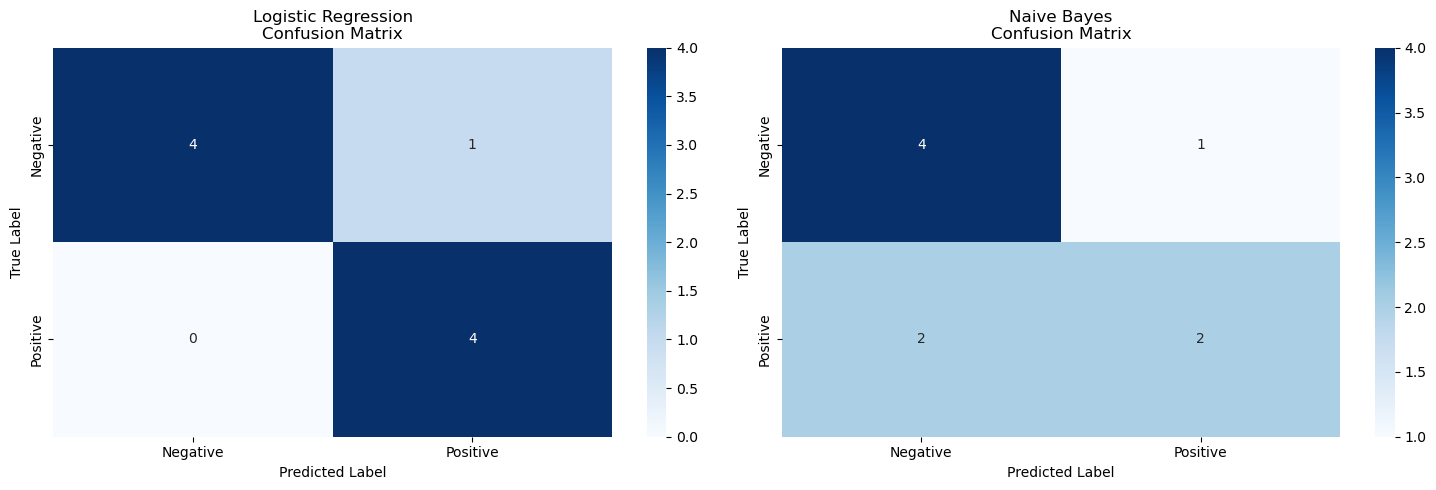

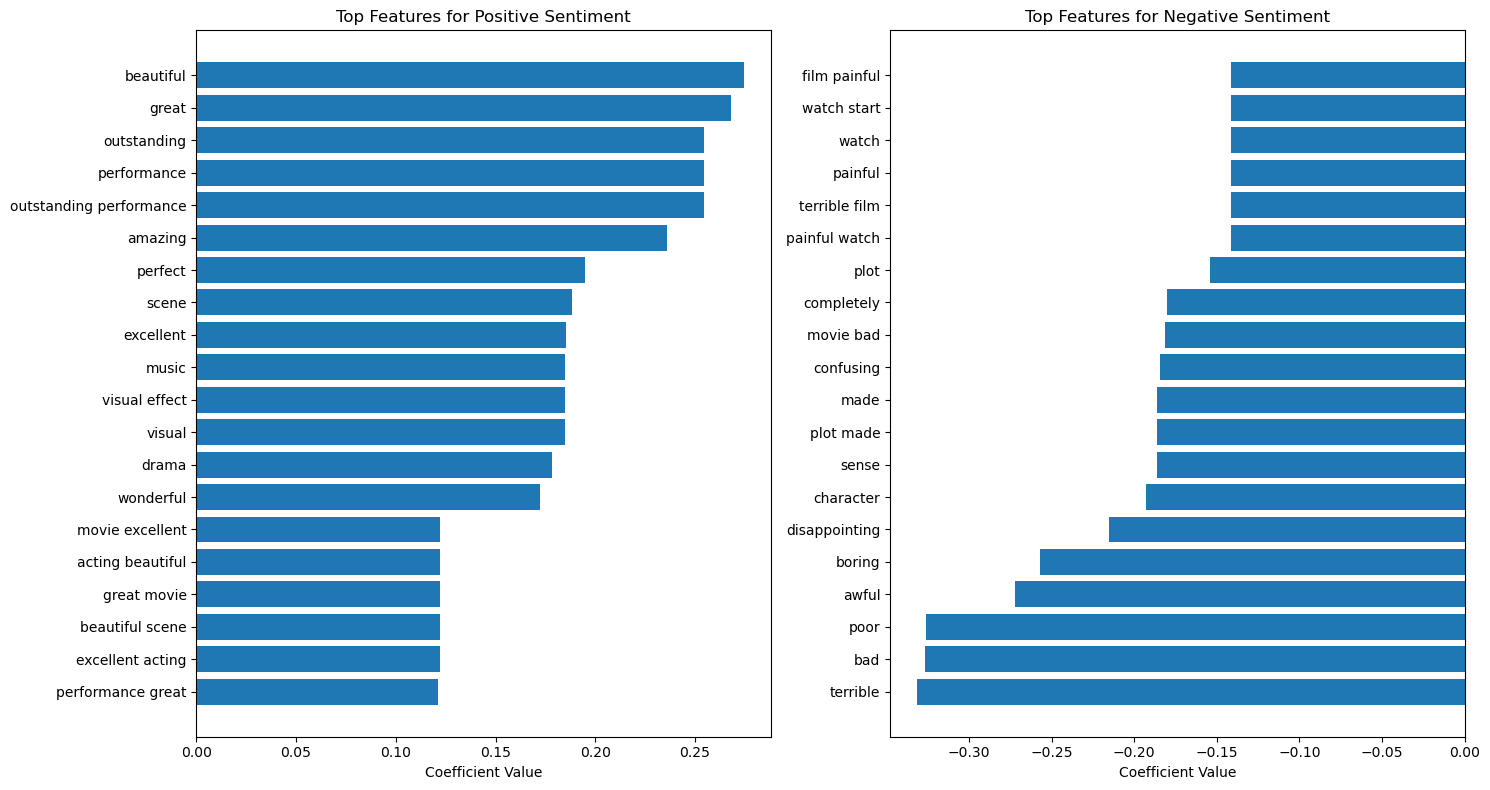

    === Sample Predictions ===

    Text: This movie was absolutely amazing! I loved every minute of it.
    Predicted Sentiment: Positive
    Confidence: 0.5754
    Probabilities: Negative=0.4246, Positive=0.5754

    Text: Terrible film with bad acting and boring plot.
    Predicted Sentiment: Negative
    Confidence: 0.5852
    Probabilities: Negative=0.5852, Positive=0.4148

    Text: The cinematography was beautiful and the story was compelling.
    Predicted Sentiment: Positive
    Confidence: 0.5627
    Probabilities: Negative=0.4373, Positive=0.5627

    Text: Worst movie I've ever seen. Complete waste of time.
    Predicted Sentiment: Negative
    Confidence: 0.5228
    Probabilities: Negative=0.5228, Positive=0.4772

    === Model Comparison Summary ===
    Logistic Regression:
      Accuracy: 0.8889
      F1-Score: 0.8889
    Naive Bayes:
      Accuracy: 0.6667
      F1-Score: 0.5714

    === Interactive Testing ===
    You can now test the model with your own text:
    Example: analyzer.predict_sentiment('Your text here')
    Available models: 'logistic_regression', 'naive_bayes'